# Classifying multi-label comments with Logistic Regression

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

## Load training and test data

In [3]:
train_df = pd.read_csv('./input/train.csv')
test_df = pd.read_csv('./input/test.csv')

### Examine the data(EDA)

In [4]:
train_df.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
99373,138bba73601cf1b8,"""\n\nThe innate immunity, i.e. phagocytosis, i...",0,0,0,0,0,0
63271,a94b9023e5792b71,Sorry that you're getting frustrated. In gener...,0,0,0,0,0,0
11476,1e5752c0cbc43f98,I think it is also necessary to focus on the c...,0,0,0,0,0,0
366,00e9db54d1e315eb,"Paula White, Joel Osteen, Marbled Cat, and a f...",0,0,0,0,0,0
87108,e900687f80c3ae70,Regarding edits made during December 13 2008 (...,0,0,0,0,0,0


훈련 데이터에서, 코멘트들은 여섯개의 카테고리로 나뉘어져 있습니다. 이는 다중 레이블 분류 문제입니다.

In [5]:
cols_target = ['obscene', 'insult', 'toxic', 'severe_toxic', 'identity_hate', 'threat']

In [6]:
# check missing values in numeric columns
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


겱측값은 존재하지 않습니다. 평균 값이 매우 작은 것을 보았을 때, 대부분 카테고리가 0으로 이루어져 있는 것 같습니다. 

In [7]:
unlabelled_in_all = train_df[(train_df['toxic']!=1) & (train_df['severe_toxic']!=1) & (train_df['threat']!=1) & (train_df['obscene']!=1) & (train_df['insult']!=1) & (train_df['identity_hate']!=1) ]
print('Percentage of unlabelled comments is', len(unlabelled_in_all)/len(train_df)*100)

Percentage of unlabelled comments is 89.83211235124176


In [8]:
# Check for any 'null' comment
no_comment = train_df[train_df['comment_text'].isnull()]
len(no_comment)

0

In [9]:
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [11]:
no_comment = test_df[test_df['comment_text'].isnull()]
no_comment

,id,comment_text


모든 훈련/테스트 셋은 코멘트를 가지고 있습니다. 따라서 결측치를 정리할 필요가 없습니다.

In [13]:
# 훈련/테스트 셋의 모든 열을 살펴봅니다.
print('Total rows in test is {}'.format(len(test_df)))
print('Total rows in train is {}'.format(len(train_df)))
print(train_df[cols_target].sum())

Total rows in test is 153164
Total rows in train is 159571
obscene           8449
insult            7877
toxic            15294
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


처음에 언급했던 것처럼 대부분의 데이터가 카테고리 분류가 이루어지지 않았습니다.

In [14]:
# 각 열들의 길이를 살펴보고 기록합니다.
train_df['char_length'] = train_df['comment_text'].apply(lambda x: len(str(x)))

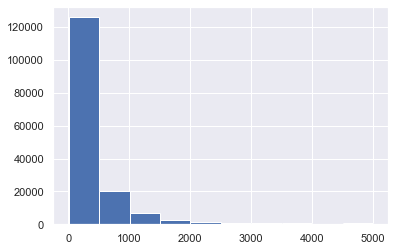

In [16]:
# 문장 길이에 대한 히스토그램을 그립니다.
sns.set()
train_df['char_length'].hist()
plt.show()

대부분의 문장 길이는 500글자 이내입니다. 가장 긴 문장은 5000자 정도 됩니다.

다음으로는, 타겟 변수간 상관관계를 살펴보겠습니다.

In [18]:
data = train_df[cols_target]

<AxesSubplot:title={'center':'Correlation of feature & targets'}>

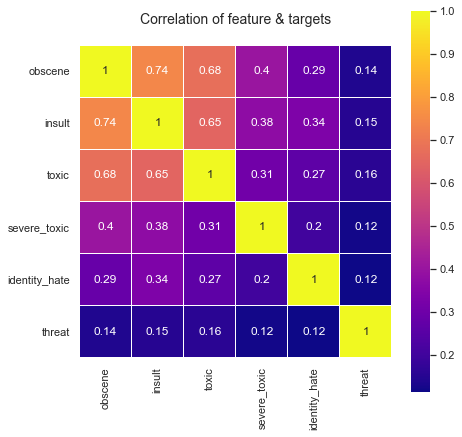

In [19]:
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of feature & targets', y=1.05, size=14)
sns.heatmap(data.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap,
            linecolor='white', annot=True)

몇 변수간 상관관계가 높음을 알 수 있습니다. (예: 모욕-음담패설은 0.74로 가장 높고, 그 다음으로 독성-음담패설, 독성-모욕 순)

테스트 데이터의 글자 길이와 분포는 어떻게 되는지 살펴보겠습니다.

In [20]:
test_df['char_length'] = test_df['comment_text'].apply(lambda x: len(str(x)))

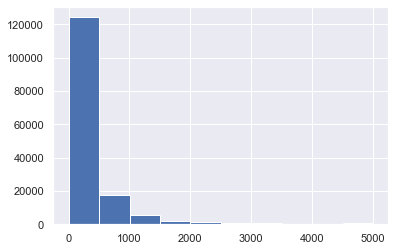

In [21]:
plt.figure()
plt.hist(test_df['char_length'])
plt.show()

테스트 데이터의 길이 분포는 훈련 데이터와 비슷합니다.

## Clean up the comment text

In [22]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [23]:
# train_df의 comment_text 정리
train_df['comment_text'] = train_df['comment_text'].map(lambda com: clean_text(com))

In [24]:
# test_df의 comment_text 정리
test_df['comment_text'] = test_df['comment_text'].map(lambda com: clean_text(com))

## Define X from entire train & test data for use in tokenization by Vectorizer

In [25]:
train_df = train_df.drop('char_length', axis=1)

In [26]:
X = train_df.comment_text
test_X = test_df.comment_text

In [27]:
print(X.shape, test_X.shape)

(159571,) (153164,)


## Vectorizer the data

In [28]:
# TfidfVectorizer을 임포트하고 인스턴스화
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(max_features=5000, stop_words='english')
vect

TfidfVectorizer(max_features=5000, stop_words='english')

In [29]:
# 훈련 데이터의 단어를 훈련시키고, 문서-단어 매트릭스 생성
X_dtm = vect.fit_transform(X)
# 문서-단어 매트릭스 실행
X_dtm

<159571x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 3178792 stored elements in Compressed Sparse Row format>

In [30]:
# 테스트 데이터의 단어를 훈련시키고, 문서-단어 매트릭스 생성
test_X_dtm = vect.transform(test_X)
# 문서-단어 매트릭스 실행
test_X_dtm

<153164x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 2618972 stored elements in Compressed Sparse Row format>

## Solving a multi-label classification problem
다중 레이블 분류 문제에 접근하는 한 가지 방법은 문제를 별도의 단일 클래스 분류기 문제로 변환하는 것입니다. 이를 '문제 변환'이라고 합니다. 세 가지 방법이 있습니다.
- 이진 관련성: 각 레이블을 별도의 단일 분류 문제로 취급하는 가장 간단한 방법입니다. 그러나 여기서 중요한 가정은 레이블 사이에 상관 관계가 없다는 것입니다.
- 분류기 체인: 이 방법은 첫 번째 분류기가 입력 X에 대해 훈련됩니다. 그 후 후속 분류기는 체인에 있는 입력 X와 모든 이전 분류기의 예측에 대해 훈련됩니다. 이 방법은 이전 타겟 변수 간의 상관 관계에서 신호를 끌어옵니다.
- 레이블 파워셋: 이 방법은 문제를 모든 고유한 레이블 조합인 다중 클래스 문제로 변환합니다. 이 문제처럼 6개의 레이블이 있는 경우, 레이블 파워셋은 실제로 이 문제를 2^6, 64 클래스 문제로 바꿀 수 있습니다.

## Binary Relevance - build a multi-label classifier using Logistic Regression

In [31]:
# 로지스틱 모델 임포트 및 인스턴스화
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
logreg = LogisticRegression(C=12.0)

# 제출 파일 생성
submission_binary = pd.read_csv('./input/sample_submission.csv')

for label in cols_target:
    print('... Processing {}'.format(label))
    y = train_df[label]
    # X_dtm과 y를 사용하여 모델 훈련
    logreg.fit(X_dtm, y)
    # 훈련 정확도 측정
    y_pred_X = logreg.predict(X_dtm)
    print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    # 예측 확률 측정
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    submission_binary[label] = test_y_prob

... Processing obscene


C:\ProgramData\Anaconda3\envs\tens_2g\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training accuracy is 0.983223768729907
... Processing insult


C:\ProgramData\Anaconda3\envs\tens_2g\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training accuracy is 0.9755344016143285
... Processing toxic


C:\ProgramData\Anaconda3\envs\tens_2g\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training accuracy is 0.9639533499194716
... Processing severe_toxic


C:\ProgramData\Anaconda3\envs\tens_2g\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training accuracy is 0.9920536939669489
... Processing identity_hate


C:\ProgramData\Anaconda3\envs\tens_2g\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training accuracy is 0.9939776024465599
... Processing threat
Training accuracy is 0.9981199591404453


C:\ProgramData\Anaconda3\envs\tens_2g\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Create submission file

In [32]:
submission_binary.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999957,0.461375,0.999965,0.050123,0.972258,0.430870
1,0000247867823ef7,0.002462,0.000442,0.000402,0.000324,0.003252,0.000408
2,00013b17ad220c46,0.010794,0.000117,0.003221,0.000035,0.007652,0.001248
3,00017563c3f7919a,0.001345,0.002154,0.000977,0.000117,0.000835,0.000034
4,00017695ad8997eb,0.019416,0.000811,0.001262,0.000602,0.003271,0.000565


In [33]:
# 제출 파일 생성
submission_binary.to_csv('submission_binary.csv', index=False)

## Classifier Chains - build a multi-label classifier using Logistic Regression

In [36]:
# 제출 파일 생성
submission_chains = pd.read_csv('./input/sample_submission.csv')

# 피쳐 추가 함수 생성
def add_feature(X, feature_to_add):
    """
    피쳐가 추가된 희소 피쳐 행렬 반환
    feature_to_dd는 피쳐의 리스트 형태가 될 수 있음
    """
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [37]:
for label in cols_target:
    print('... Processing {}'.format(label))
    y = train_df[label]
    # X_dtm과 y를 사용하여 모델 훈련
    logreg.fit(X_dtm, y)
    # 훈련 정확도 계산
    y_pred_X = logreg.predict(X_dtm)
    print('Training Accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    # test_X 로 부터 예측
    test_y = logreg.predict(test_X_dtm)
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    submission_chains[label] = test_y_prob
    # 현재 레이블을 X_dtm에 체인
    X_dtm = add_feature(X_dtm, y)
    print("Shape of X_dtm is now {}".format(X_dtm.shape))
    # 현재 레이블 예측을 test_X_dtm에 체인
    test_X_dtm = add_feature(test_X_dtm, test_y)
    print('Shape of test_X_dtm is now {}'.format(test_X_dtm.shape))

... Processing obscene


C:\ProgramData\Anaconda3\envs\tens_2g\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training Accuracy is 0.983223768729907
Shape of X_dtm is now (159571, 5001)
Shape of test_X_dtm is now (153164, 5001)
... Processing insult


C:\ProgramData\Anaconda3\envs\tens_2g\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training Accuracy is 0.9818137380852411
Shape of X_dtm is now (159571, 5002)
Shape of test_X_dtm is now (153164, 5002)
... Processing toxic


C:\ProgramData\Anaconda3\envs\tens_2g\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training Accuracy is 0.9675692951726818
Shape of X_dtm is now (159571, 5003)
Shape of test_X_dtm is now (153164, 5003)
... Processing severe_toxic


C:\ProgramData\Anaconda3\envs\tens_2g\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training Accuracy is 0.9930689160311084
Shape of X_dtm is now (159571, 5004)
Shape of test_X_dtm is now (153164, 5004)
... Processing identity_hate


C:\ProgramData\Anaconda3\envs\tens_2g\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training Accuracy is 0.995600704388642
Shape of X_dtm is now (159571, 5005)
Shape of test_X_dtm is now (153164, 5005)
... Processing threat
Training Accuracy is 0.9985649021438733
Shape of X_dtm is now (159571, 5006)
Shape of test_X_dtm is now (153164, 5006)


C:\ProgramData\Anaconda3\envs\tens_2g\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Create submission file

In [38]:
submission_chains.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999974,4.160071e-01,0.999965,0.193270,0.893688,0.601750
1,0000247867823ef7,0.002636,8.248506e-10,0.000402,0.000072,0.003677,0.000137
2,00013b17ad220c46,0.007978,2.287001e-10,0.003221,0.000009,0.004084,0.000527
3,00017563c3f7919a,0.001130,1.253288e-08,0.000977,0.000063,0.000569,0.000004
4,00017695ad8997eb,0.019876,1.205648e-09,0.001262,0.000158,0.001547,0.000103


In [39]:
# 제출 파일 생성
submission_chains.to_csv('submission_chains.csv', index=False)

## Create a combined submission

In [40]:
# 제출 파일 생성
submission_combined = pd.read_csv('./input/sample_submission.csv')

이진 관련성과 분류기 체인을 평균함으로써 결합합니다.

In [ ]:
for label in cols_target:
    submission_combined[label] = 0.5 * (su)